In [1]:
import sys 
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np 

module_path = str(Path.cwd().parents[0]/'Encoder')
if module_path not in sys.path:
    sys.path.append(module_path)

from Encoder import Encoder

file_path = "C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Fibonacci_data\\Fibonacci_data_10000_events_varlen.csv"

In [2]:
def train_val_test_split(df):
    # np.split() to split the dataset
    # train_znorm.sample(frac=1, random_state=42) to shuffle the dataset random
    # [int(.6*len(train_znorm)),int(.8*len(train_znorm))] first split after 60% of the data. second split after 80%
    # 60% train set - 20% validation set - 20% test set
    df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)),int(.8*len(df))])
    return df_train, df_validate, df_test

def clean_data(array): 
    """Takes an 2 dimensional array with np.isnan() values, 
    cuts the np.isnan() values out and applies a pre-padding. It
    returns a 2 dimensional array where all rows have the same length"""
    clean_list = []
    for row in range (0, len(array)):
        temp_list = np.array([x for x in array[row] if not np.isnan(x)])
        pad_width = len(array[0])-len(temp_list)
        pad_array = np.zeros(pad_width)
        padded_list = np.concatenate((pad_array, temp_list))
        clean_list.append(padded_list)  
    return clean_list

def define_features_and_targets(array):
    """Takes a 2 dimensional array and defines its targets and features. 
    Since the encoders output is of the same shape as the encoder input, 
    we take the features as all elements in the row exept the last, and the targets 
    all elements in the row exept the first."""
    features = []
    targets = []
    for row in range (0, len(array)): 
        temp_features = array[row][0:-1]
        temp_targets = array[row][1:]
        features.append(temp_features)
        targets.append(temp_targets)

    return features, targets

Load the generated fibonacci data and make a train, test, validation split. Assign targets and features to each of these sets, and convert this to tensors to make it a valid input for the Encoder model. 

In [3]:
df_data = pd.DataFrame(pd.read_csv(file_path))

# Make train, validation and test split
df_train, df_validate, df_test = train_val_test_split(df_data)

# Convert df to array, remove nans and apply pre-padding
train_set = df_train.to_numpy()
validate_set = df_validate.to_numpy()

# Store test to .csv file
df_test.to_csv("C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Fibonacci_data\\var_length_testdata.csv")

train_set = clean_data(train_set)
validate_set = clean_data(validate_set)

# Define targets and features
train_features, train_targets = define_features_and_targets(train_set)
validate_features, validate_targets = define_features_and_targets(validate_set)

# Store as a tensorflow tensor to make it a valid input for the encoder model
train_features = tf.constant(train_features)
train_targets = tf.constant(train_targets)
validate_features = tf.constant(validate_features)
validate_targets = tf.constant(validate_targets)

Define the model hyper parameters.

In [4]:
d_model = 512
d_ff = 2048
batch_size = 64
h = 8 
n = 6
d_k = 8
d_v = int(batch_size/h)
rate = 0.1

n_events = df_data.shape[0]
vocab_size = int(np.max(np.max(df_data), axis=0)+1) # add one because we include 0

padding_mask = None
seq_length = vocab_size
print(vocab_size)

90


c:\Users\nvanb\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


Define loss and optimizer and build the Encoder model.

In [5]:
# Define the loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [6]:
encoder_model = Encoder(batch_size, seq_length, h, n, d_model, d_ff, d_k, d_v, rate, vocab_size, d_model, padding_mask, training=True)
encoder_model.build(input_shape=(n_events, seq_length))
encoder_model.summary()

Tensor("Shape:0", shape=(2,), dtype=int32)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding_fixed_  multiple                 0 (unused)
 weights (PositionalEmbeddin                                     
 gFixedWeights)                                                  
                                                                 
 encoder_layer (EncoderLayer  multiple                 0 (unused)
 )                                                               
                                                                 
 encoder_layer_1 (EncoderLay  multiple                 0 (unused)
 er)                                                             
                                                                 
 encoder_layer_2 (EncoderLay  multiple                 0 (unused)
 er)                                                             
                

Train the Encoder model and save its weights

In [7]:
num_epochs = 10
encoder_model.compile(optimizer, loss=loss_function, metrics='accuracy')
history = encoder_model.fit(train_features, train_targets, epochs=num_epochs, validation_data=(validate_features, validate_targets))

encoder_model.save_weights("C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Fibonacci_data\\model_varlen.keras")

Epoch 1/10
Tensor("encoder/Shape:0", shape=(2,), dtype=int32)
Tensor("encoder/Shape:0", shape=(2,), dtype=int32)
188/188 [==============================] - 50s 221ms/step - loss: 1.6454 - accuracy: 0.4256 - val_loss: 0.8707 - val_accuracy: 0.5341
Epoch 2/10
188/188 [==============================] - 45s 241ms/step - loss: 0.4415 - accuracy: 0.8187 - val_loss: 0.8522 - val_accuracy: 0.6737
Epoch 3/10
188/188 [==============================] - 49s 262ms/step - loss: 0.2227 - accuracy: 0.9077 - val_loss: 0.0946 - val_accuracy: 0.9688
Epoch 4/10
188/188 [==============================] - 46s 245ms/step - loss: 0.8549 - accuracy: 0.7096 - val_loss: 1.0241 - val_accuracy: 0.5563
Epoch 5/10
188/188 [==============================] - 51s 269ms/step - loss: 0.5875 - accuracy: 0.7559 - val_loss: 0.1883 - val_accuracy: 0.9178
Epoch 6/10
188/188 [==============================] - 46s 245ms/step - loss: 0.1554 - accuracy: 0.9364 - val_loss: 0.1939 - val_accuracy: 0.9261
Epoch 7/10
188/188 [========

Plot loss and validation loss during training

In [8]:
epoch_history = [_ for _ in range (0,num_epochs)]
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

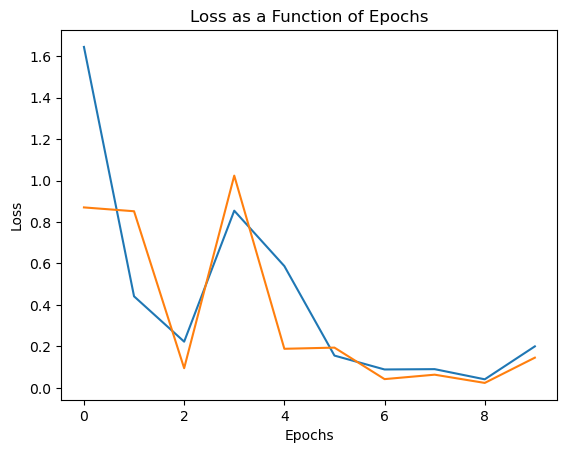

In [9]:
import matplotlib.pyplot as plt

plt.plot(epoch_history, loss_history)
plt.plot(epoch_history, val_loss_history)
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()